# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is loaded from [this url]( https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv). We provide you the code to read the csv from an url. 

## 02 - Load Data
Let's start by loading the time series of the challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data/monthly_champagne_sales.csv")

👉 Convert dataframe with datetime objects as index to make it look like this
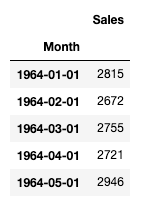

In [13]:
df.Month = pd.to_datetime(df.Month)
df.set_index("Month", inplace=True)

In [14]:
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

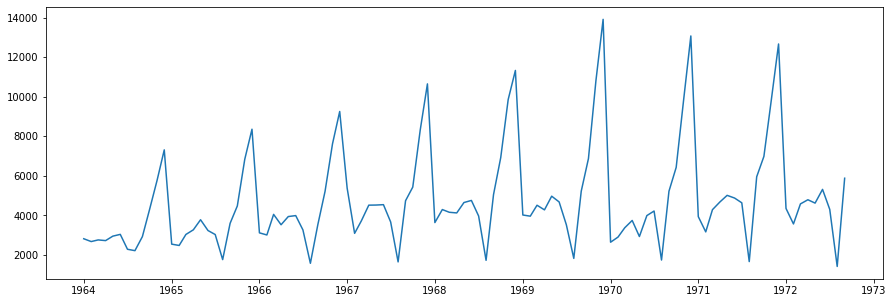

In [17]:
plt.figure(figsize = (15, 5))
plt.plot(df);

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

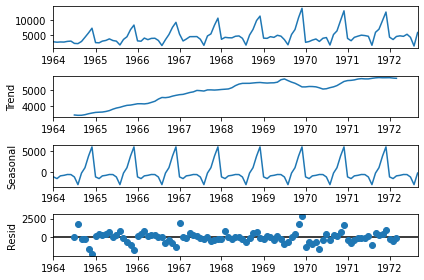

In [19]:
result_add = seasonal_decompose(df, model = "additive")
result_add.plot();

In [20]:
result_mult = seasonal_decompose(df, model = "multiplicative")

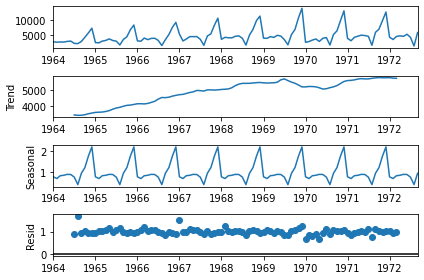

In [21]:
result_mult.plot(); 

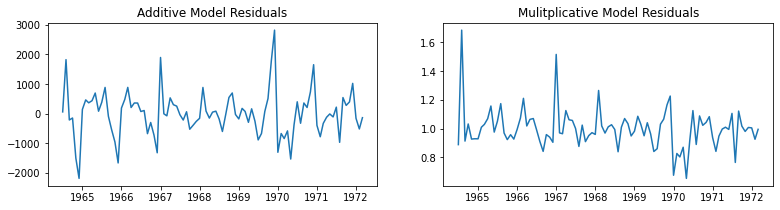

In [28]:
f, ax = plt.subplots(1, 2, figsize = (13, 3))
ax[0].plot(result_add.resid), ax[0].set_title("Additive Model Residuals")
ax[1].plot(result_mult.resid), ax[1].set_title("Mulitplicative Model Residuals");

👉 De-seasonalize this time serie using the decomposition of your choice

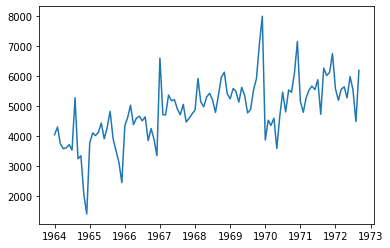

In [36]:
plt.plot(df.Sales - result_add.seasonal);

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [56]:
df_train = df[:"1969"]
df_test = df["1970":]

In [60]:
df_train.tail()

,Sales
Month,
1969-08-01,1821
1969-09-01,5222
1969-10-01,6872
1969-11-01,10803
1969-12-01,13916


In [59]:
df_test.head()

,Sales
Month,
1970-01-01,2639
1970-02-01,2899
1970-03-01,3370
1970-04-01,3740
1970-05-01,2927


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [66]:
from statsmodels.tsa.stattools import adfuller
adfuller(df.Sales)[1]

0.3639157716602452

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


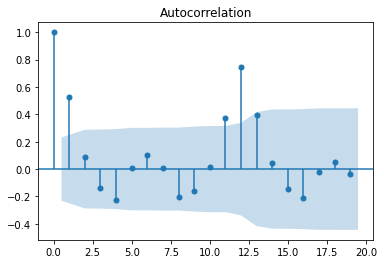

In [69]:
plot_acf(df_train.Sales);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

In [76]:
y_diff_12 = df_train.Sales.diff(12).dropna()

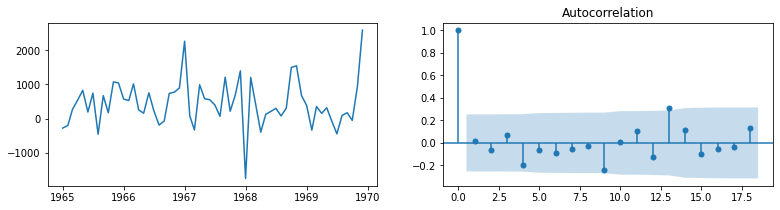

In [78]:
fig, ax = plt.subplots(1, 2, figsize = (13, 3))
ax[0].plot(y_diff_12)
plot_acf(y_diff_12, ax = ax[1]);

In [79]:
adfuller(y_diff_12)[1]

2.647350636254994e-09

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

0.0005183923752540649

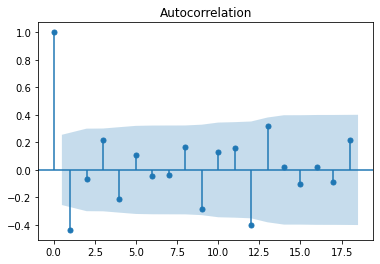

In [81]:
plot_acf(y_diff_12.diff(1).dropna());
adfuller(y_diff_12.diff(1).dropna())[1]

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

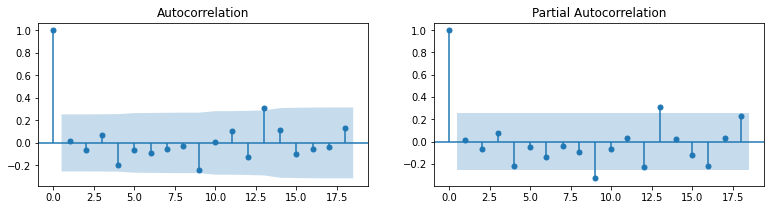

In [83]:
fig, ax = plt.subplots(1, 2, figsize = (13,3))
plot_acf(y_diff_12, ax = ax[0])
plot_pacf(y_diff_12, ax = ax[1]);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [84]:
from pmdarima.arima import auto_arima

In [85]:
model = auto_arima(df_train.Sales, 
                  m = 12, # seasonal frequency
                  seasonal= True,
                  stepwise= True,
                  D = 1, 
                  start_p = 0, max_p = 2, 
                  start_q = 0, max_q = 2, 
                  start_P = 0, max_P = 2, 
                  start_Q = 0, max_Q = 2, 
                  njobs = -1, trace = True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.11 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.661 seconds


The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [104]:
model = SARIMAX(df_train.Sales, order = (1, 0, 1), seasonal_order=(0,1,0,12))

/home/jakob/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [105]:
model = model.fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09842D+01    |proj g|=  8.58613D+00

At iterate    5    f=  6.70941D+00    |proj g|=  1.16592D-02

At iterate   10    f=  6.62844D+00    |proj g|=  2.54808D-02

At iterate   15    f=  6.61636D+00    |proj g|=  2.68446D-03

At iterate   20    f=  6.61384D+00    |proj g|=  1.66038D-03

At iterate   25    f=  6.60685D+00    |proj g|=  6.09042D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

/home/jakob/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -475.693
Date:                             Thu, 30 Jun 2022   AIC                            957.387
Time:                                     20:00:43   BIC                            963.670
Sample:                                 01-01-1964   HQIC                           959.845
                                      - 12-01-1969                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.008    126.940      0.000       0.984       1.015
ma.L1         -0.9957      0.072    -13.878      0.000      -1.136      -0.855
sigma2      4.472e+05   6.99e-08    6.4e+12      0.000    4.47e+05    4.47e+05
===================================================================================
Ljung-Box (Q):                       46.87   Jarque-Bera (JB):                15.64
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.31
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.46e+28. Standard errors may be unstable.
"""

In [106]:
preds = model.predict(n_periods=len(df_test), return_conf_int=True)
preds

1964-01-01        0.000000
1964-02-01       32.943206
1964-03-01       63.462372
1964-04-01       94.225562
1964-05-01      123.901643
                  ...     
1969-08-01     2142.685188
1969-09-01     5463.741657
1969-10-01     7334.785336
1969-11-01    10265.275383
1969-12-01    11744.399980
Freq: MS, Length: 72, dtype: float64

In [107]:
central = pd.Series(preds[0], index = df_test.index)
upper = pd.Series(preds[1][:, 0], index = df_test.index)
lower = pd.Series(preds[1][:, 1], index = df_test.index)

IndexError: invalid index to scalar variable.

👇 Run the cell below to plot your predictions against reality

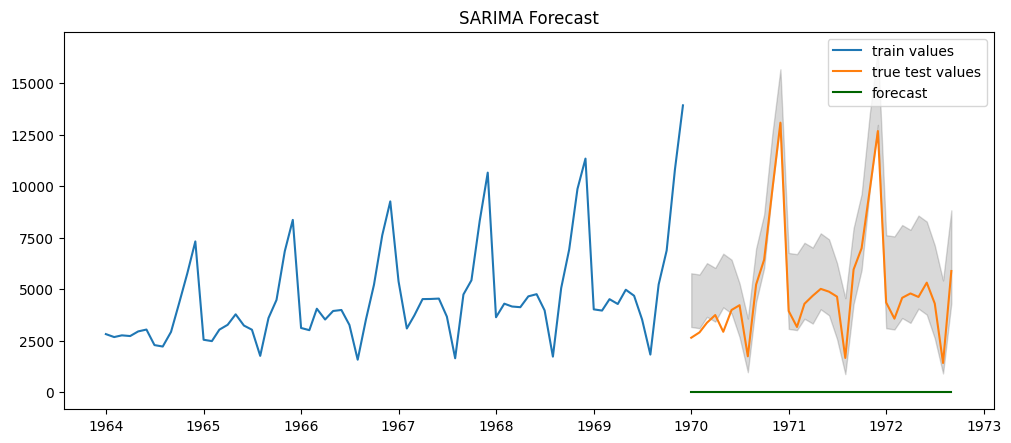

In [108]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values

# Drop nan


# create df_train and df_test 


In [ ]:
# Keep track of test_indexes

In [ ]:
# Create X, y

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA